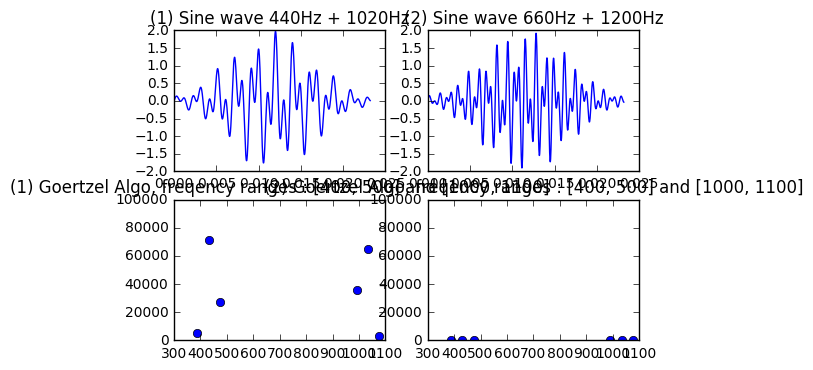

In [1]:
# https://gist.github.com/sebpiq/4128537

import math

def goertzel(samples, sample_rate, *freqs):
    """
    Implementation of the Goertzel algorithm, useful for calculating individual
    terms of a discrete Fourier transform.

    `samples` is a windowed one-dimensional signal originally sampled at `sample_rate`.

    The function returns 2 arrays, one containing the actual frequencies calculated,
    the second the coefficients `(real part, imag part, power)` for each of those frequencies.
    For simple spectral analysis, the power is usually enough.

    Example of usage :
        
        freqs, results = goertzel(some_samples, 44100, (400, 500), (1000, 1100))
    """
    window_size = len(samples)
    f_step = sample_rate / float(window_size)
    f_step_normalized = 1.0 / window_size

    # Calculate all the DFT bins we have to compute to include frequencies
    # in `freqs`.
    bins = set()
    for f_range in freqs:
        f_start, f_end = f_range
        k_start = int(math.floor(f_start / f_step))
        k_end = int(math.ceil(f_end / f_step))

        if k_end > window_size - 1: raise ValueError('frequency out of range %s' % k_end)
        bins = bins.union(range(k_start, k_end))

    # For all the bins, calculate the DFT term
    n_range = range(0, window_size)
    freqs = []
    results = []
    for k in bins:

        # Bin frequency and coefficients for the computation
        f = k * f_step_normalized
        w_real = 2.0 * math.cos(2.0 * math.pi * f)
        w_imag = math.sin(2.0 * math.pi * f)

        # Doing the calculation on the whole sample
        d1, d2 = 0.0, 0.0
        for n in n_range:
            y  = samples[n] + w_real * d1 - d2
            d2, d1 = d1, y

        # Storing results `(real part, imag part, power)`
        results.append((
            0.5 * w_real * d1 - d2, w_imag * d1,
            d2**2 + d1**2 - w_real * d1 * d2)
        )
        freqs.append(f * sample_rate)
    return freqs, results


if __name__ == '__main__':
    # quick test
    import numpy as np
    import pylab

    # generating test signals
    SAMPLE_RATE = 44100
    WINDOW_SIZE = 1024
    t = np.linspace(0, 1, SAMPLE_RATE)[:WINDOW_SIZE]
    sine_wave = np.sin(2*np.pi*440*t) + np.sin(2*np.pi*1020*t)
    sine_wave = sine_wave * np.hamming(WINDOW_SIZE)
    sine_wave2 = np.sin(2*np.pi*880*t) + np.sin(2*np.pi*1500*t)
    sine_wave2 = sine_wave2 * np.hamming(WINDOW_SIZE)

    # applying Goertzel on those signals, and plotting results
    freqs, results = goertzel(sine_wave, SAMPLE_RATE, (400, 500),  (1000, 1100))

    pylab.subplot(2, 2, 1)
    pylab.title('(1) Sine wave 440Hz + 1020Hz')
    pylab.plot(t, sine_wave)

    pylab.subplot(2, 2, 3)
    pylab.title('(1) Goertzel Algo, freqency ranges : [400, 500] and [1000, 1100]')
    pylab.plot(freqs, np.array(results)[:,2], 'o')
    pylab.ylim([0,100000])

    freqs, results = goertzel(sine_wave2, SAMPLE_RATE, (400, 500),  (1000, 1100))

    pylab.subplot(2, 2, 2)
    pylab.title('(2) Sine wave 660Hz + 1200Hz')
    pylab.plot(t, sine_wave2)

    pylab.subplot(2, 2, 4)
    pylab.title('(2) Goertzel Algo, freqency ranges : [400, 500] and [1000, 1100]')
    pylab.plot(freqs, np.array(results)[:,2], 'o')
    pylab.ylim([0,100000])

    pylab.show()